# Assignment 2

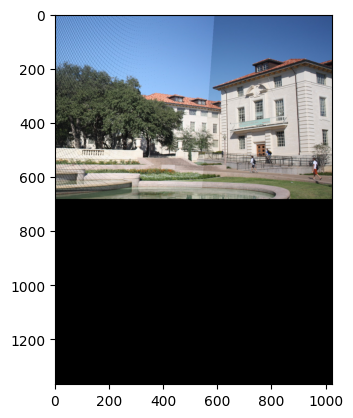

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_keypoints_and_descriptors(image1, image2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    return kp1, des1, kp2, des2

def get_best_matches(desc1, desc2, ratio_thresh=0.75):
    brute_force = cv2.BFMatcher()
    matches = brute_force.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    return good_matches

def compute_homography_matrix(kp1, kp2, good_matches):
    points1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
    points2 = np.array([kp2[m.trainIdx].pt for m in good_matches])
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)
    return H

def forward_warp(image, H):
    height, width = image.shape[:2]
    coordinates = np.column_stack([np.repeat(np.arange(width), height), np.tile(np.arange(height), width)])
    homogeneous_coordinates = np.column_stack([coordinates, np.ones(coordinates.shape[0])])
    warped_coordinates = np.dot(H, homogeneous_coordinates.T).T
    warped_coordinates /= warped_coordinates[:, 2:3]
    warped_coordinates = np.floor(warped_coordinates).astype(int)

    result = np.zeros_like(image)
    for i, (x, y) in enumerate(coordinates):
        xp, yp = warped_coordinates[i, 0], warped_coordinates[i, 1]
        if 0 <= xp < width and 0 <= yp < height:
            result[yp, xp] = image[y, x]
    return result

def create_mosaic(image1, image2, H):
    warped_image = forward_warp(image1, H)
    offset_x, offset_y = 0, 0
    width = max(image2.shape[1], warped_image.shape[1])
    height = image2.shape[0] + warped_image.shape[0]

    mosaic = np.zeros((height, width, 3), dtype=np.uint8)
    mosaic[offset_y:offset_y+image2.shape[0], offset_x:offset_x+image2.shape[1]] = image2

    # Combine the warped image into the mosaic
    for i in range(warped_image.shape[0]):
        for j in range(warped_image.shape[1]):
            if np.any(warped_image[i, j] != 0):
                mosaic[i, j] = warped_image[i, j]

    return mosaic

# Loading images
pan_image1 = cv2.imread('/content/sample_data/pano_image2.jpg')
pan_image2 = cv2.imread('/content/sample_data/pano_image1.jpg')

# Detect keypoints and descriptors
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(pan_image1, pan_image2)

# Find good matches
good_matches = get_best_matches(des1, des2)

# Compute homography matrix using RANSAC
homography_matrix = compute_homography_matrix(ky1, ky2, good_matches)

# Create mosaic
mosaic = create_mosaic(pan_image1, pan_image2, homography_matrix)

# Display the result
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.show()


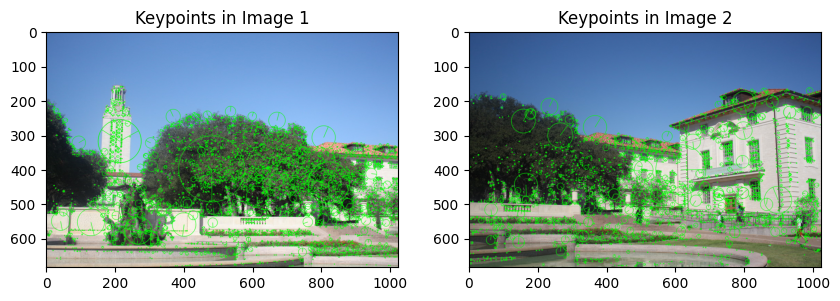

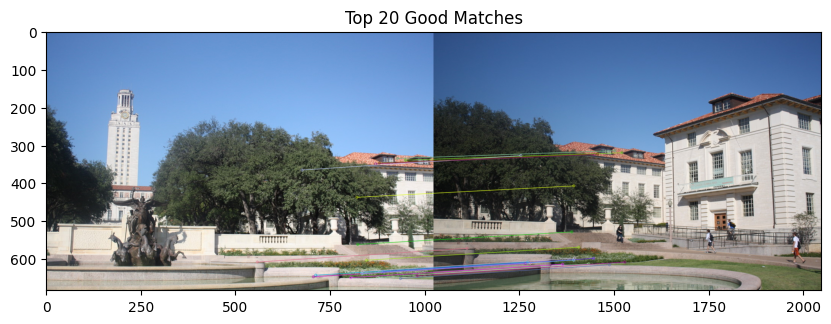

Computed Homography Matrix:
[[-2.16407783e-03  1.25315751e-04  9.59398210e-01]
 [-2.85291902e-04 -2.02614983e-03  2.82034518e-01]
 [-4.74960094e-07 -4.03407419e-08 -1.64939029e-03]]


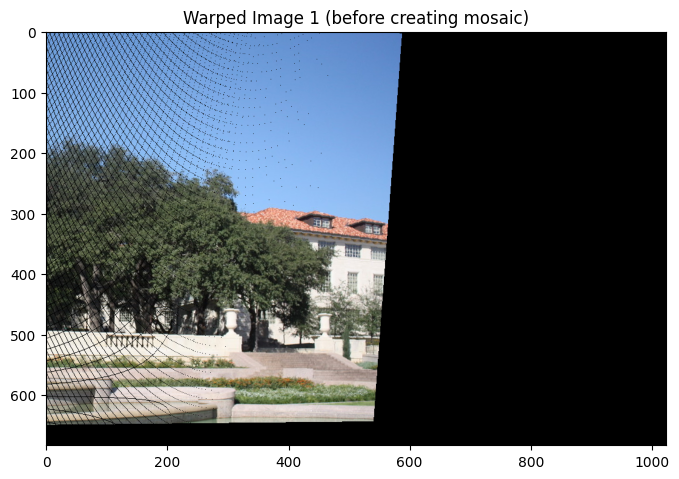

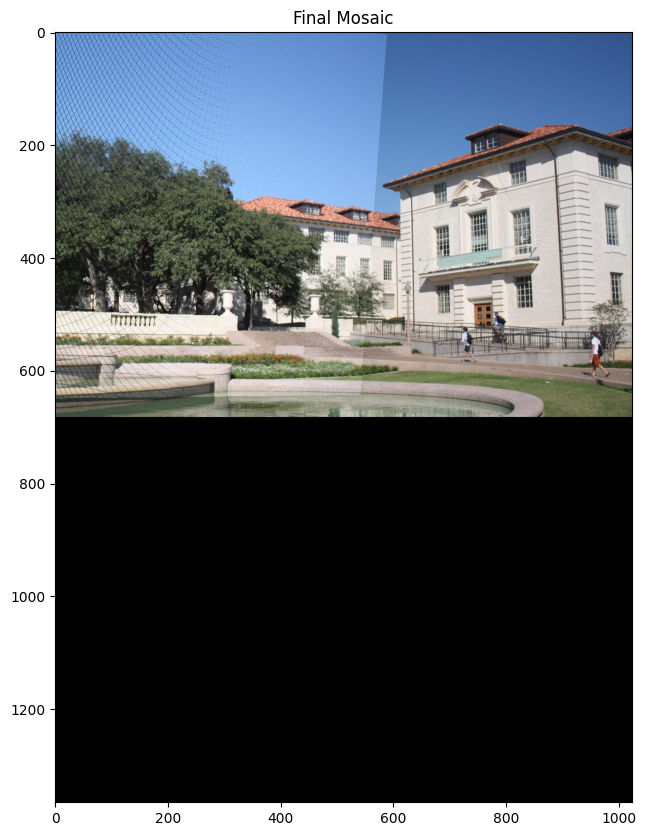

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_keypoints_and_descriptors(image1, image2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    return kp1, des1, kp2, des2

def get_best_matches(desc1, desc2, ratio_thresh=0.75):
    brute_force = cv2.BFMatcher()
    matches = brute_force.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    return good_matches

def compute_homography_matrix(correspondences):
    if len(correspondences) < 4:
        raise ValueError("At least 4 correspondences are required.")
    A = []
    for x, y, xp, yp in correspondences:
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1, :].reshape(3, 3)
    return H

def forward_warp(image, H):
    height, width = image.shape[:2]
    coordinates = np.column_stack([np.repeat(np.arange(width), height), np.tile(np.arange(height), width)])
    homogeneous_coordinates = np.column_stack([coordinates, np.ones(coordinates.shape[0])])
    warped_coordinates = np.dot(H, homogeneous_coordinates.T).T
    warped_coordinates /= warped_coordinates[:, 2:3]
    warped_coordinates = np.floor(warped_coordinates).astype(int)

    result = np.zeros_like(image)
    for i, (x, y) in enumerate(coordinates):
        xp, yp = warped_coordinates[i, 0], warped_coordinates[i, 1]
        if 0 <= xp < width and 0 <= yp < height:
            result[yp, xp] = image[y, x]
    return result

def create_mosaic(image1, image2, H):
    warped_image = forward_warp(image1, H)
    offset_x, offset_y = 0, 0
    width = max(image2.shape[1], warped_image.shape[1])
    height = image2.shape[0] + warped_image.shape[0]

    mosaic = np.zeros((height, width, 3), dtype=np.uint8)
    mosaic[offset_y:offset_y+image2.shape[0], offset_x:offset_x+image2.shape[1]] = image2

    # Combine the warped image into the mosaic
    for i in range(warped_image.shape[0]):
        for j in range(warped_image.shape[1]):
            if np.any(warped_image[i, j] != 0):
                mosaic[i, j] = warped_image[i, j]

    return mosaic

# Loading images
pan_image1 = cv2.imread('/content/sample_data/pano_image2.jpg')
pan_image2 = cv2.imread('/content/sample_data/pano_image1.jpg')

# Detect keypoints and descriptors
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(pan_image1, pan_image2)

# Display keypoints on the images
image1_with_kp = cv2.drawKeypoints(pan_image1, ky1, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
image2_with_kp = cv2.drawKeypoints(pan_image2, ky2, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_with_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 1")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_with_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 2")
plt.show()

# Find good matches
good_matches = get_best_matches(des1, des2)

# Display good matches
matched_image = cv2.drawMatches(pan_image1, ky1, pan_image2, ky2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Top 20 Good Matches")
plt.show()

# Collect correspondences for homography computation
correspondences = []
for m in good_matches[:10]:
    x, y = ky1[m.queryIdx].pt
    xp, yp = ky2[m.trainIdx].pt
    correspondences.append((x, y, xp, yp))

# Compute homography matrix using your function
homography_matrix = compute_homography_matrix(correspondences)

# Display the computed homography matrix
print("Computed Homography Matrix:")
print(homography_matrix)

# Create and display warped image before creating mosaic
warped_image = forward_warp(pan_image1, homography_matrix)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title("Warped Image 1 (before creating mosaic)")
plt.show()

# Create mosaic
mosaic = create_mosaic(pan_image1, pan_image2, homography_matrix)

# Display the final mosaic
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.title("Final Mosaic")
plt.show()


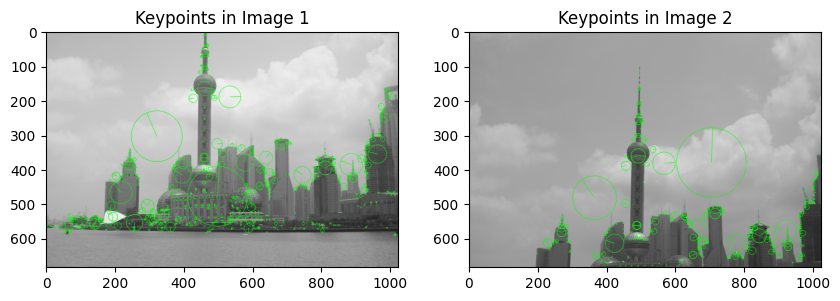

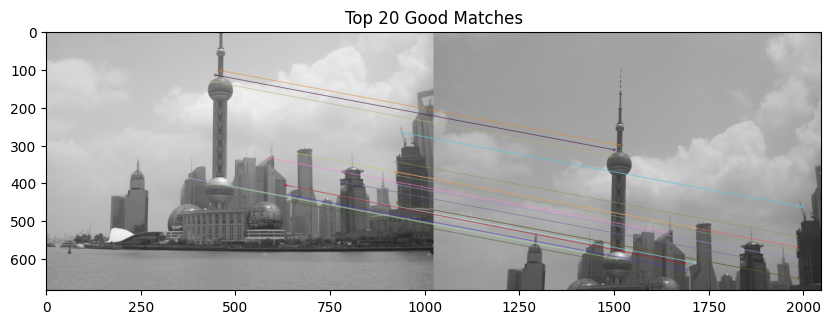

Homography Matrix (1st Stitching):
[[ 4.68144934e-03 -1.98159134e-04  2.07692653e-01]
 [-2.65227667e-05  4.55651123e-03  9.78160297e-01]
 [-6.91100133e-08 -3.42663369e-07  4.84528542e-03]]


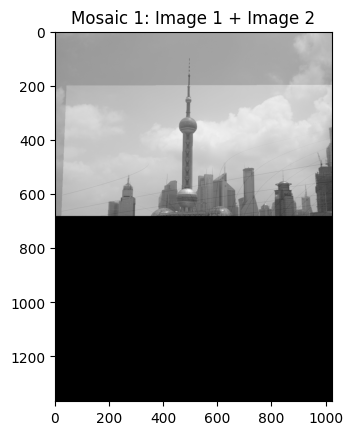

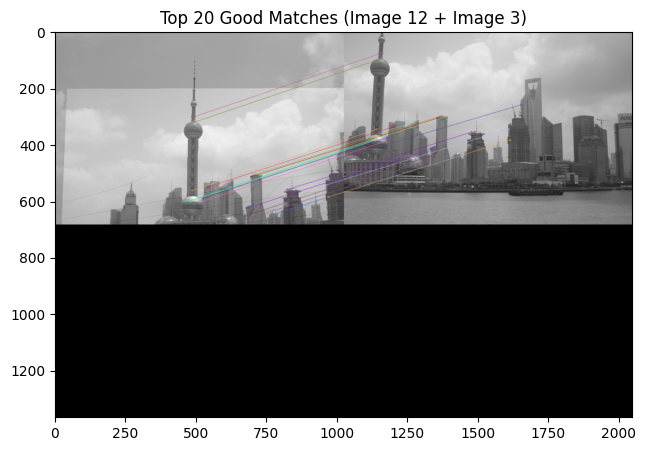

Homography Matrix (2nd Stitching):
[[-2.23274498e-03  5.74038947e-05  8.10465074e-01]
 [-1.64441233e-04 -2.19637564e-03  5.85775539e-01]
 [-2.68731295e-07 -1.65843646e-07 -1.88199278e-03]]


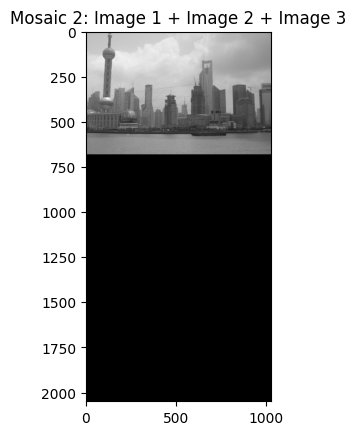

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

def get_keypoints_and_descriptors(image1, image2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    return kp1, des1, kp2, des2

def get_best_matches(desc1, desc2, ratio_thresh=0.75):
    brute_force = cv2.BFMatcher()
    matches = brute_force.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    return good_matches

def compute_homography_matrix_dlt(correspondences):
    A = []
    for x, y, xp, yp in correspondences:
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1, :].reshape(3, 3)
    return H

def compute_reprojection_error(H, correspondences):
    correspondences = np.array(correspondences)
    points1 = correspondences[:, :2]
    points2 = correspondences[:, 2:]
    points1_homogeneous = np.c_[points1, np.ones(len(points1))]
    projected_points = np.dot(H, points1_homogeneous.T).T
    projected_points /= projected_points[:, 2:3]
    error = np.linalg.norm(projected_points[:, :2] - points2, axis=1)
    return error

def ransac_homography(kp1, kp2, matches, num_iterations=1000, reproj_thresh=4.0):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        sample_matches = random.sample(matches, 4)
        correspondences = [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1],
                            kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in sample_matches]

        H = compute_homography_matrix_dlt(correspondences)
        errors = compute_reprojection_error(H, [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1],
                                                 kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in matches])

        inliers = [m for m, e in zip(matches, errors) if e < reproj_thresh]
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H
            best_inliers = inliers

    return best_H, best_inliers

def forward_warp(image, H):
    height, width = image.shape[:2]
    coordinates = np.column_stack([np.repeat(np.arange(width), height), np.tile(np.arange(height), width)])
    homogeneous_coordinates = np.column_stack([coordinates, np.ones(coordinates.shape[0])])
    warped_coordinates = np.dot(H, homogeneous_coordinates.T).T
    warped_coordinates /= warped_coordinates[:, 2:3]
    warped_coordinates = np.floor(warped_coordinates).astype(int)

    result = np.zeros_like(image)
    for i, (x, y) in enumerate(coordinates):
        xp, yp = warped_coordinates[i, 0], warped_coordinates[i, 1]
        if 0 <= xp < width and 0 <= yp < height:
            result[yp, xp] = image[y, x]
    return result

def create_mosaic(image1, image2, H):
    warped_image = forward_warp(image1, H)
    offset_x, offset_y = 0, 0
    width = max(image2.shape[1], warped_image.shape[1])
    height = image2.shape[0] + warped_image.shape[0]

    mosaic = np.zeros((height, width, 3), dtype=np.uint8)
    mosaic[offset_y:offset_y+image2.shape[0], offset_x:offset_x+image2.shape[1]] = image2

    for i in range(warped_image.shape[0]):
        for j in range(warped_image.shape[1]):
            if np.any(warped_image[i, j] != 0):
                mosaic[i, j] = warped_image[i, j]

    return mosaic

# Loading images
shan_image1 = cv2.imread('/content/sample_data/shanghai-21.png')
shan_image2 = cv2.imread('/content/sample_data/shanghai-22.png')
shan_image3 = cv2.imread('/content/sample_data/shanghai-23.png')

# Step 1: Stitch the first two images (shan_image1 and shan_image2)
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(shan_image1, shan_image2)
matches = get_best_matches(des1, des2)

# Visualize Keypoints in both images
image1_with_kp = cv2.drawKeypoints(shan_image1, ky1, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
image2_with_kp = cv2.drawKeypoints(shan_image2, ky2, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_with_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 1")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_with_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints in Image 2")
plt.show()

# Display Matches between images
good_matches = get_best_matches(des1, des2)
matched_image = cv2.drawMatches(shan_image1, ky1, shan_image2, ky2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Top 20 Good Matches")
plt.show()

# Use more than 10 correspondences to improve accuracy
num_matches = 50
correspondences = []
for m in good_matches[:num_matches]:
    x, y = ky1[m.queryIdx].pt
    xp, yp = ky2[m.trainIdx].pt
    correspondences.append((x, y, xp, yp))

# Compute homography matrix using RANSAC
H, mask = ransac_homography(ky1, ky2, good_matches[:num_matches])
print("Homography Matrix (1st Stitching):")
print(H)

# Create mosaic of the first two images and visualize it
image12 = create_mosaic(shan_image1, shan_image2, H)
plt.imshow(image12)
plt.title("Mosaic 1: Image 1 + Image 2")
plt.show()

# Step 2: Stitch the result (image12) with the third image (shan_image3)
ky1, des1, ky2, des2 = get_keypoints_and_descriptors(image12, shan_image3)
matches = get_best_matches(des1, des2)

# Display Matches between image12 and image3
good_matches = get_best_matches(des1, des2)
matched_image = cv2.drawMatches(image12, ky1, shan_image3, ky2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title("Top 20 Good Matches (Image 12 + Image 3)")
plt.show()

# Use more than 10 correspondences to improve accuracy
correspondences = []
for m in good_matches[:num_matches]:
    x, y = ky1[m.queryIdx].pt
    xp, yp = ky2[m.trainIdx].pt
    correspondences.append((x, y, xp, yp))

# Compute homography matrix using RANSAC
H, mask = ransac_homography(ky1, ky2, good_matches[:num_matches])
print("Homography Matrix (2nd Stitching):")
print(H)

# Create mosaic of the first three images and visualize it
image123 = create_mosaic(image12, shan_image3, H)
plt.imshow(image123)
plt.title("Mosaic 2: Image 1 + Image 2 + Image 3")
plt.show()
